In [ ]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from scipy.io import loadmat
import os
from collections import OrderedDict
import mne
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import warnings

In [2]:
warnings.simplefilter("ignore", category=DeprecationWarning)
print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
def my_var_cut_fn(epochs, plow, phigh, to_plot=True):
    """
    Variance base trial rejection function
    """
    trl_var, trlindx = np.empty((0,1),'float'), np.arange(0,len(epochs))
    for trnum in range(len(epochs)):
        trl_var = np.vstack((trl_var, max(np.var(np.squeeze(epochs[trnum].get_data()), axis=1))))
    lim1 = (trl_var < np.percentile(trl_var, plow, interpolation='midpoint')).flatten()
    lim2 = (trl_var > np.percentile(trl_var, phigh, interpolation='midpoint')).flatten()
    outlr_idx = trlindx[lim1].tolist()+ trlindx[lim2].tolist()

    if to_plot:
        plt.figure, plt.scatter(trlindx, trl_var, marker='o',
                s=50, c='g', label='Good trials'),
        plt.ylabel('Max. Variance across channels-->')
        plt.scatter(outlr_idx, trl_var[outlr_idx], marker='o',
                s=50, c='r', label='Variance based bad trials'),
        plt.xlabel('Trial number-->')
        plt.scatter(badtrls, trl_var[badtrls], marker='o', s=50,
                c='orange', label='Manually assigned bad trials')
        plt.ylim(min(trl_var)-min(trl_var)*0.01,
                max(trl_var)+max(trl_var)*0.01),
        plt.title('Max. variance distribution')
        plt.legend()
        plt.show()
    bad_trials = np.union1d(badtrls, outlr_idx)
    print('Removed trials: %s\n' % bad_trials)
    return bad_trials

In [4]:
#%% Set parameters, directories and filenames
more_plots = True
par = {'badch'    : [],
       'stimch'   : 'STI 014'}
code_dir = '/home/anakin/Documents/BeamComp_CodeRepo/LCMV_pipelines/'
data_dir = '/home/anakin/Documents/BeamComp_DataRepo/'

par['event_dict'] = OrderedDict()
par['event_dict']['VEF_UR'] = 1
par['event_dict']['VEF_LR'] = 2
par['event_dict']['AEF_Re'] = 3
par['event_dict']['VEF_LL'] = 4
par['event_dict']['AEF_Le'] = 5
par['event_dict']['VEF_UL'] = 8
par['event_dict']['SEF_Lh'] = 16
par['event_dict']['SEF_Rh'] = 32
st_len = len(par['event_dict'])

act_dip_ = loadmat(code_dir + 'multimodal_biomag_Xfit_results.mat')
act_dip  = act_dip_['multimodal_biomag_Xfit_diploc'][:, 3:6]

par['act_loc'] = OrderedDict()
par['act_loc']['VEF_UR'] = act_dip[0]
par['act_loc']['VEF_LR'] = act_dip[1]
par['act_loc']['AEF_Re'] = act_dip[2]
par['act_loc']['VEF_LL'] = act_dip[3]
par['act_loc']['AEF_Le'] = act_dip[4]
par['act_loc']['VEF_UL'] = act_dip[5]
par['act_loc']['SEF_Lh'] = act_dip[6]
par['act_loc']['SEF_Rh'] = act_dip[7]

data_path = data_dir + 'MEG/Human_EF/'
filename = 'multimodal_raw.fif'    # or, multimodal_raw_tsss.fif
fname = data_path + filename
subjects_dir, subject = data_dir + 'MRI/', 'BeamCompMRI'

In [5]:
# trans = subjects_dir + subject + '/mri/transforms/' + subject + '-trans.fif'
trans = subjects_dir + subject + '/mri/brain-neuromag/sets/' + 'BeamCompMRI-amit-131118-MNEicp-trans.fif'

In [6]:
mrifile = subjects_dir + subject + '/mri/T1.mgz'
surffile = subjects_dir + subject + '/bem/watershed/' + subject + '_brain_surface'
dfname = os.path.split(os.path.splitext(fname)[0])[1]

In [7]:
print(dfname)
print(fname)

multimodal_raw
/home/anakin/Documents/BeamComp_DataRepo/MEG/Human_EF/multimodal_raw.fif


In [8]:
raw = mne.io.read_raw_fif(fname, allow_maxshield=False, preload=True, verbose=True)

Opening raw data file /home/anakin/Documents/BeamComp_DataRepo/MEG/Human_EF/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
Reading 0 ... 392999  =      0.000 ...   654.328 secs...


In [9]:
raw.info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 1 EOG
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: off, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>

In [10]:
raw.info['projs']==[]

False

In [11]:
if not raw.info['projs']==[]:
    bads = ['MEG 0442']
    raw.drop_channels(bads)
events = mne.find_events(raw, stim_channel=par['stimch'],
                         min_duration=0.001, shortest_event=1)

942 events found
Event IDs: [ 1  2  3  4  5  8 16 32]


In [12]:
events

array([[186831,      0,      1],
       [187268,      0,      8],
       [187699,      0,      3],
       ...,
       [575445,      0,      4],
       [575883,      0,      8],
       [576321,      0,      1]])

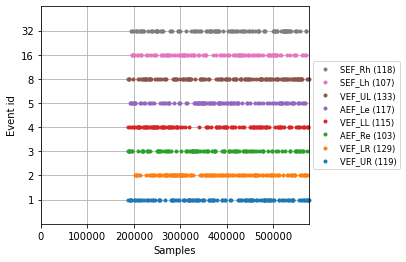

<Raw | multimodal_raw.fif, 305 x 393000 (654.3 s), ~917.8 MB, data loaded>

In [13]:
events = events[events[:,1]==0]
if more_plots:
    mne.viz.plot_events(events, first_samp=0,
        event_id=par['event_dict'], equal_spacing=True, show=True)
raw.pick_types(meg=True)

In [14]:
#%% Apply filter if required
raw.notch_filter(50, filter_length='auto', phase='zero', picks=None)
raw.filter(2, 95, picks=None, filter_length='auto',
    l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1,
    method='fir', iir_params=None, phase='zero', fir_window='hamming',
    fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),
    pad='reflect_limited', verbose=True)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3965 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 95 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 95.00 Hz
- Upper transition bandwidth: 

<Raw | multimodal_raw.fif, 305 x 393000 (654.3 s), ~917.8 MB, data loaded>

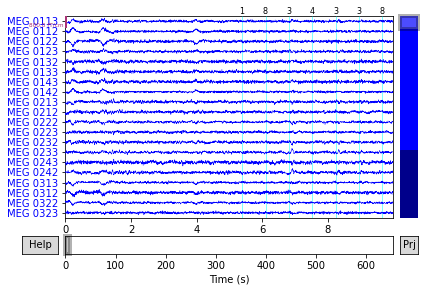

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


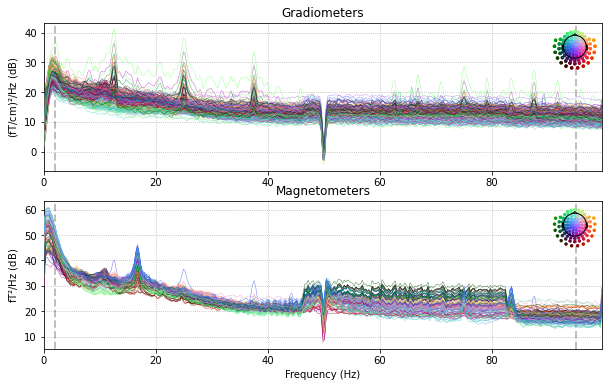

In [15]:
if more_plots:
    raw.plot(events=events)
    raw.plot_psd(fmin=0, fmax=100, proj=False, verbose=True)

In [16]:
#%% Epoching the data
reject = dict(grad=7000e-13, mag=7e-12, eog=250e-6)
epochs = mne.Epochs(raw, events, par['event_dict'], -0.5, 0.5,
        baseline=(-0.5,0), picks=None, preload=True, reject=None,
        flat=None, proj=False, decim=1, reject_tmin=None,
        reject_tmax=None, detrend=None, on_missing='error',
        reject_by_annotation=True, verbose=True)

Not setting metadata
Not setting metadata
941 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
Loading data for 941 events and 601 original time points ...
1 bad epochs dropped


In [17]:
epochs

<Epochs |  940 events (all good), -0.499488 - 0.499488 sec, baseline [-0.5, 0] sec, ~1.29 GB, data loaded,
 'AEF_Le': 117
 'AEF_Re': 103
 'SEF_Lh': 107
 'SEF_Rh': 118
 'VEF_LL': 115
 'VEF_LR': 129
 'VEF_UL': 133
 'VEF_UR': 118>

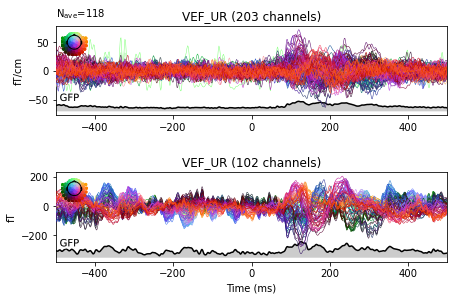

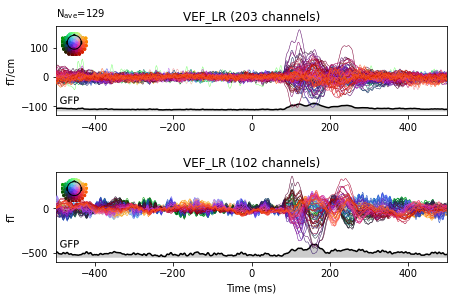

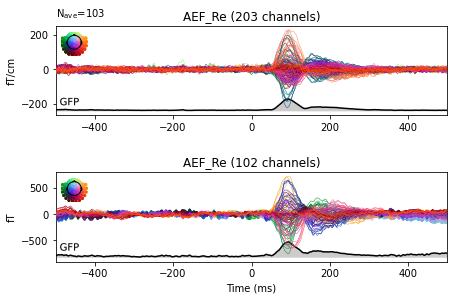

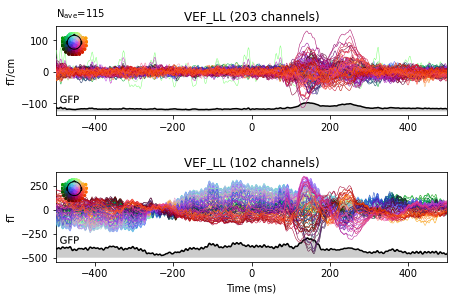

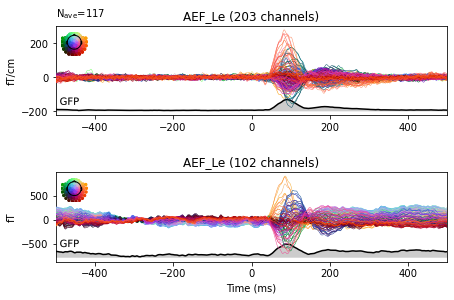

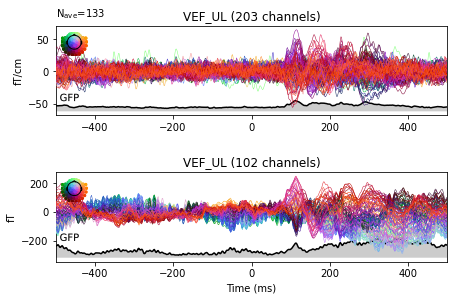

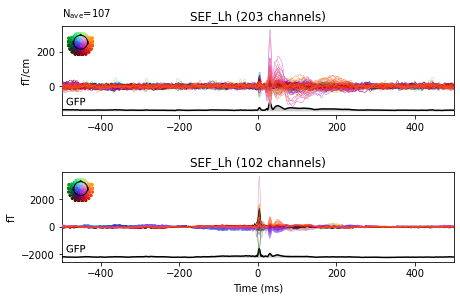

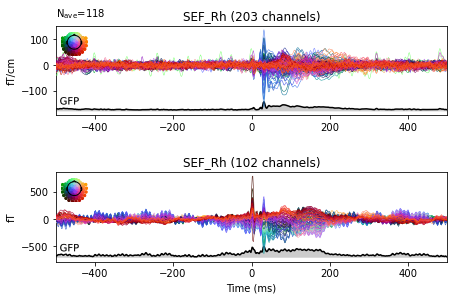

In [18]:
if more_plots:
    for stimcat in list(par['event_dict'].keys())[0:8]:
        epochs[stimcat].average().plot(spatial_colors=True,
            titles=stimcat, gfp=True, time_unit='ms')

In [19]:
#%% Compute source space && forward solution/leadfield
model = mne.make_bem_model(subject=subject, ico=4, conductivity=(0.33,),
        subjects_dir=subjects_dir, verbose=True)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.36 -24.79  -5.00 mm
Surfaces passed the basic topology checks.
Complete.



In [20]:
bem = mne.make_bem_solution(model)

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [21]:
src_vol = mne.setup_volume_source_space(subject=subject, pos=5.0,
    mri=mrifile, bem=None, surface=surffile, mindist=2.5, exclude=10.0,
    subjects_dir=subjects_dir, volume_label=None, add_interpolator=True,
    verbose=True)

Boundary surface file : /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/bem/watershed/BeamCompMRI_brain_surface
grid                  : 5.0 mm
mindist               : 2.5 mm
Exclude               : 10.0 mm
MRI volume            : /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/mri/T1.mgz

Reading /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/mri/T1.mgz...

Loaded bounding surface from /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/bem/watershed/BeamCompMRI_brain_surface (10242 nodes)
Surface CM = (  -0.4  -24.8   -5.1) mm
Surface fits inside a sphere with radius   98.9 mm
Surface extent:
    x =  -74.1 ...   75.1 mm
    y = -104.5 ...   70.4 mm
    z =  -89.6 ...   65.3 mm
Grid extent:
    x =  -75.0 ...   80.0 mm
    y = -105.0 ...   75.0 mm
    z =  -90.0 ...   70.0 mm
39072 sources before omitting any.
28708 sources after omitting infeasible sources not within 10.0 - 98.9 mm.
Source spaces are in MRI coordinates.
Checking that the sources are i

Using surface: /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/bem/inner_skull.surf
Using surface: /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/bem/outer_skull.surf
Using surface: /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/bem/outer_skin.surf


/home/anakin/anaconda3/envs/mne/lib/python3.8/site-packages/mne/viz/utils.py:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


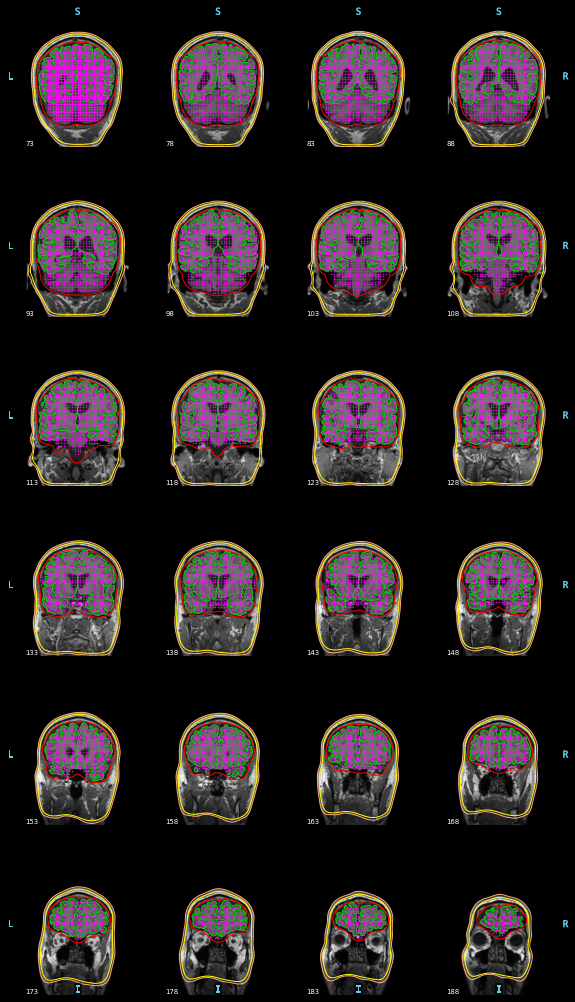

In [22]:
if more_plots:
    mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
        orientation='coronal', slices=range(73,193,5),
        brain_surfaces='pial', src=src_vol, show=True)

In [23]:
if more_plots:
    mne.viz.plot_alignment(epochs.info, trans=trans, subject=subject,
        subjects_dir=subjects_dir, fig=None, 
        surfaces=['head-dense', 'inner_skull'], coord_frame='head',
        show_axes=True, meg=False, eeg='original', dig=True, ecog=True,
        bem=None, seeg=True, src=src_vol, mri_fiducials=False, verbose=True)

Using BeamCompMRI-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Using pyvista 3d backend.



In [24]:
fwd = mne.make_forward_solution(epochs.info, trans=trans,
    src=src_vol, bem=bem, meg=True, eeg=False, mindist=2.5,
    n_jobs=4)

print("Leadfield size : %d sensors x %d dipoles" % fwd['sol']['data'].shape)

Source space          : <SourceSpaces: [<volume, shape=(32, 37, 33), n_used=14503>] MRI (surface RAS) coords, subject 'BeamCompMRI', ~73.7 MB>
MRI -> head transform : /home/anakin/Documents/BeamComp_DataRepo/MRI/BeamCompMRI/mri/brain-neuromag/sets/BeamCompMRI-amit-131118-MNEicp-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 14503 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999849  0.007341  0.015721       2.30 mm
    -0.012380  0.936690  0.349941      31.00 mm
    -0.012157 -0.350083  0.936640      51.30 mm
     0.000000  0.000000  0.000000       1.00

Read 305 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.999533  0.030220 -0.004530      -1.47 mm
    -0.030521  0.994591 -0.099281      -4.03 mm
     0.001505  0.099373  0.9

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.5s remaining:   16.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Para

Computing MEG at 14503 source locations (free orientations)...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.5s remaining:    4.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.8s finished



Finished.
Leadfield size : 305 sensors x 43509 dipoles


In [25]:
#%% Apply LCMV Beamformer
stimcat = list(par['event_dict'].keys())[0]
print(stimcat)
par['ctrlwin'] = [-0.200, -0.050]
par['actiwin'] = [0.050, 0.200]

dfname_stimcat = dfname + '_' + stimcat
print(dfname_stimcat)

epochs_stimcat = epochs[stimcat]
    
#% % Find trial variance > index outliers> remove beyond plow and phigh percentile
badtrls, plow, phigh = [], 2.0, 98.0

############################
bad_trials = my_var_cut_fn(epochs_stimcat, plow, phigh, to_plot=False)

VEF_UR
multimodal_raw_VEF_UR
Removed trials: [ 12.  61.  72.  81.  90. 105.]



VEF_UR
Removed trials: [ 12.  61.  72.  81.  90. 105.]


6 trial to remove from total 118 trials...
No. of remaining trials = 112
Dropped 6 epochs: 12.0, 61.0, 72.0, 81.0, 90.0, 105.0
Computing rank from data with rank=None
    Using tolerance 3.9e-09 (2.2e-16 eps * 305 dim * 5.8e+04  max singular value)
    Estimated rank (mag + grad): 298
    MEG: rank 298 computed from 305 data channels with 7 projectors
    Created an SSP operator (subspace dimension = 7)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 305 -> 298
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 10192
[done]
Computing rank from data with rank=None
    Using tolerance 4.8e-09 (2.2e-16 eps * 305 dim * 7.1e+04  max singular value)
    Estimated rank (mag + grad): 298
    MEG: rank 298 computed from 305 data channels with 7 projectors
    Created an SSP operator (subspace dimension = 7)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 305

    203 planar channels
    limit = 13037/14503 = 10.000835
    scale = 7.23668e-08 exp = 0.199
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 7)
Computing rank from covariance with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 305 dim * 8  max singular value)
    Estimated rank (mag + grad): 298
    MEG: rank 298 computed from 305 data channels with 7 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 3.74803
    scaling factor to adjust the trace = 2.12888e+20
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 97
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 7)
    Created the whitener using a noise covariance matrix with rank 298 (7 small eigenvalues omitted)
Picked 305 chan

Computing rank from covariance with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 305 dim * 8.4  max singular value)
    Estimated rank (mag + grad): 298
    MEG: rank 298 computed from 305 data channels with 7 projectors
Making LCMV beamformer with rank {'meg': 298}
Computing inverse operator with 305 channels.
    305 out of 305 channels remain after picking
Selected 305 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 7)
Computing rank from covariance with rank={'meg': 298}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 14503 sources
Filter computation complete
Act_Sourceloc for multimodal_raw_AEF_Le= [64.4  8.2 62.6]
Est_Sourceloc for multimodal_raw_AEF_Le= [57.   0.5 56.5]
Loc_error for multimodal_raw_AEF_Le= 12.3 mm
Point Spread Volume (PSV) for multimodal_raw_AEF_Le= 6250.0 mm
VEF_UL
Removed trials: [ 2. 20. 31. 44. 

<ipython-input-26-d7eebe480431>:43: RuntimeWarning: SNR estimation did not converge
  snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)


Computing inverse operator with 305 channels.
    305 out of 305 channels remain after picking
Selected 305 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 7)
Computing rank from covariance with rank={'meg': 298}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 14503 sources
Filter computation complete
Act_Sourceloc for multimodal_raw_SEF_Lh= [43.3  8.2 99.5]
Est_Sourceloc for multimodal_raw_SEF_Lh= [ 42.6   7.  102.3]
Loc_error for multimodal_raw_SEF_Lh= 3.1 mm
Point Spread Volume (PSV) for multimodal_raw_SEF_Lh= 1750.0 mm
SEF_Rh
Removed trials: [30. 42. 47. 69. 81. 82.]


6 trial to remove from total 118 trials...
No. of remaining trials = 112
Dropped 6 epochs: 30.0, 42.0, 47.0, 69.0, 81.0, 82.0
Computing rank from data with rank=None
    Using tolerance 3.3e-09 (2.2e-16 eps * 305 dim * 4.9e+04  max singular value)
    Estimated 

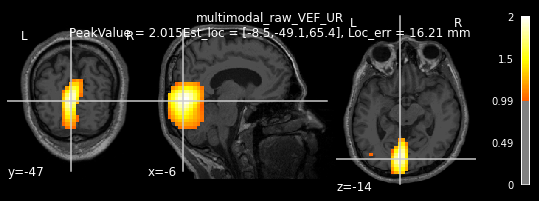

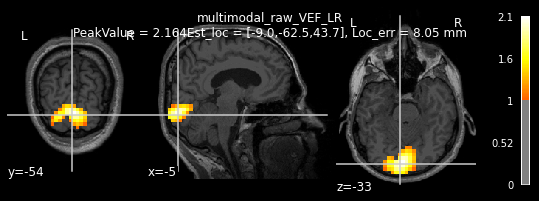

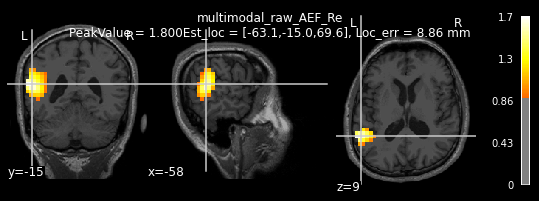

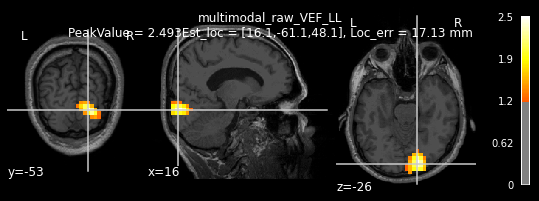

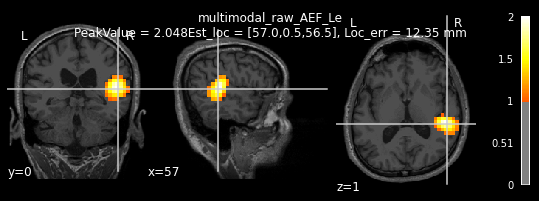

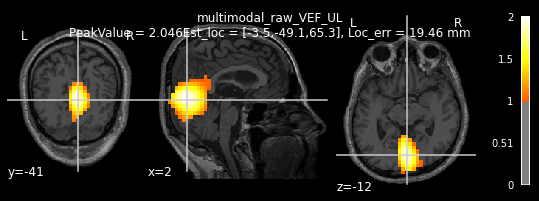

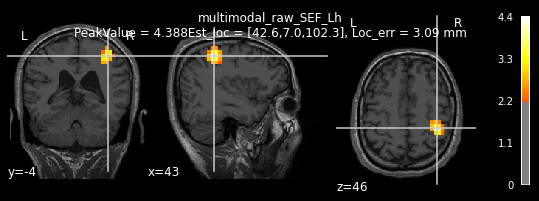

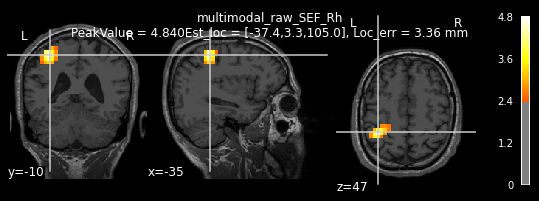

In [26]:
#%% Apply LCMV Beamformer
for stimcat in list(par['event_dict'].keys()):
    print(stimcat)
    if 'VEF' in stimcat:
        par['ctrlwin'] = [-0.200, -0.050]
        par['actiwin'] = [0.050, 0.200]
    elif 'AEF' in stimcat:
        par['ctrlwin'] = [-0.150, -0.020]
        par['actiwin'] = [0.020, 0.150]
    elif 'SEF' in stimcat:
        par['ctrlwin'] = [-0.100, -0.010]
        par['actiwin'] = [0.010, 0.100]
    dfname_stimcat = dfname + '_' + stimcat
    
    epochs_stimcat = epochs[stimcat]
    
    #% % Find trial variance > index outliers> remove beyond plow and phigh percentile
    badtrls, plow, phigh = [], 2.0, 98.0
    bad_trials = my_var_cut_fn(epochs_stimcat, plow, phigh, to_plot=False)
    print('\n%d trial to remove from total %d trials...\nNo. of remaining trials = %d' % (len(bad_trials),
                                                                                          len(epochs_stimcat),
                                                                                          len(epochs_stimcat)-len(bad_trials)))
    epochs_stimcat.drop(bad_trials, reason='variance based rejection', verbose=True)
    bad_trials = []
    
    # Compute covariance
    noise_cov = mne.compute_covariance(epochs_stimcat,
                    tmin=par['ctrlwin'][0], tmax=par['ctrlwin'][1], method='empirical',
                    verbose=True)
    data_cov = mne.compute_covariance(epochs_stimcat,
                    tmin=par['actiwin'][0], tmax=par['actiwin'][1], method='empirical',
                    verbose=True)
    
    evoked = epochs_stimcat.average()
    evoked = evoked.crop(par['actiwin'][0], par['actiwin'][1])
    
    # Pull rank from preprocessing history
    cov_rank = None if epochs_stimcat.info['proc_history']==[] else int(epochs_stimcat.info['proc_history'][0]['max_info']['sss_info']['nfree'])
    
    # Compute SNR
    inverse_operator = mne.minimum_norm.make_inverse_operator(evoked.info, fwd, noise_cov,
                          rank=cov_rank, loose=1, depth=0.199, verbose=True)
    snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)
    peak_ch, peak_time = evoked.get_peak(ch_type='grad')
    tstep = 1000 / (evoked.info['sfreq'] * 1000)
    tp = int(peak_time // tstep - evoked.times[0]//tstep)
    SNR = snr[tp]
    
    # Compute filter and output
    filters = mne.beamformer.make_lcmv(epochs_stimcat.info, fwd, data_cov, reg=0.05,
                  noise_cov=noise_cov, pick_ori='max-power', rank=cov_rank,
                  weight_norm='nai', reduce_rank=True, verbose=True)
    
    stc = mne.beamformer.apply_lcmv(evoked, filters, max_ori_out='signed', verbose=True)
    stc = np.abs(stc)
    src_peak, t_peak = stc.get_peak()
    timepoint = int(t_peak//stc.tstep - stc.times[0]//stc.tstep)
    
    #% % Detect peak over summed power over time:: Stable over time
    stc_pow_series = np.square(stc)
    stc_power = stc_pow_series.sum()
    
    src_peak, _ = stc_power.get_peak()
    est_loc = fwd['src'][0]['rr'][src_peak]*1000
    
    #% % Calculate localisation error 
    loc_err = np.sqrt(np.sum(np.square(par['act_loc'][stimcat]-est_loc)));
    stc_power_data = stc_power.copy().data
    n_act_grid = len(stc_power_data[stc_power_data > (stc_power_data.max()*0.50)])
    PSVol      = n_act_grid * (5.0 ** 3)
    
    print('Act_Sourceloc for %s' %dfname_stimcat + '= %s' % str(par['act_loc'][stimcat]))
    print('Est_Sourceloc for %s' %dfname_stimcat + '= %s' % str(np.around(est_loc,1)))
    print('Loc_error for %s' %dfname_stimcat + '= %.1f mm' %loc_err)
    print('Point Spread Volume (PSV) for %s' %dfname_stimcat + '= %.1f mm' %PSVol)
    
    #% % Plot the activation
    img = stc.as_volume(fwd['src'], dest='mri', mri_resolution=False, format='nifti1')
    plot_stat_map(index_img(img, timepoint), mrifile, threshold=stc.data.max()*0.50)
    plt.suptitle('%s\n'%dfname_stimcat +
                 'PeakValue = %.3f' % stc.data.max() + 'Est_loc = [%.1f,%.1f,%.1f], ' %tuple(est_loc) +
                 'Loc_err = %.2f mm' % loc_err, fontsize=12, color='white')